# 摘要

期货期限结构的定义和经济解释, 展期收益率的定义和建模, 利用期限结构的期货交易策略

In [1]:
# 初始化
import sys
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

import QuantStudio.api as QS

# 期限结构

**升/贴水**：描述一个标的物价格相对于另一个标的物价格的高低关系，一个标的物比另一个标的物价格高，则称前者升水，而后者贴水。

商品期货的期限结构是指商品期货价格与不同的到期期限的关系。一般来说商品期限结构特点分为两种：
* **Backwardation**: 现货价格 > 近月合约价格 > 远月合约价格，也称为现货溢价，远月贴水或者反向市场。
* **Contango**: 现货价格 < 近月合约价格 < 远月合约价格，也称为期货溢价，近月贴水或者正向市场。

<img src=".\images\期限结构.PNG" width=500 height=227>

**基差（Basis）**：现货价格 - 期货价格。

**基差率**：基差 / 现货价格 * 100%

**期限价差（Calendar Spread）**：指相同标的不同到期日的期货之间的价差，也称为月差。

In [2]:
# 基础数据
Symbol = "M"
Exchg = "DCE"# 交易所

StartDT = dt.datetime(2016, 1, 1)# 回测开始日期
EndDT = dt.datetime(2018, 12, 31)# 回测截止日期

# 获取时间序列
WDB = QS.FactorDB.WindDB2()
WDB.connect()
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid=Exchg, start_dt=StartDT, end_dt=EndDT)

# 获取期货连续合约 ID
MID, SID = Symbol+"."+Exchg, Symbol+"_S."+Exchg# 期货主力和次主力合约 ID
CCIDs = [MID, SID] + WDB.getFutureID(future_code=Symbol, contract_type="连续合约")# 所有的连续合约

# 获取现货价格
import mysql.connector
Conn = mysql.connector.connect(host="127.0.0.1", port="3306", user="hst", password="shuntai11", database="qsdata")
SQLStr = ("SELECT DateTime, `价格` FROM qsdata.`商品期货现货日行情` WHERE `来源`='生意社' AND ID='%s' ORDER BY DateTime" % (Symbol, ))
SpotPrice = pd.read_sql_query(SQLStr, Conn, index_col=["DateTime"], parse_dates=["DateTime"]).iloc[:, 0].loc[DTs].fillna(method="ffill")

# 获取连续合约的月合约映射
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
ContractMapping = FT.readData(factor_names=["映射月合约Wind代码"], ids=CCIDs, dts=DTs).iloc[0,:,:]

# 获取连续合约的价格
FT = WDB.getTable("中国商品期货日行情")
CCPrice = FT.readData(factor_names=["结算价(元)", "收盘价(元)"], ids=CCIDs, dts=DTs)
CCPrice.items = ["结算价", "收盘价"]
WDB.disconnect();

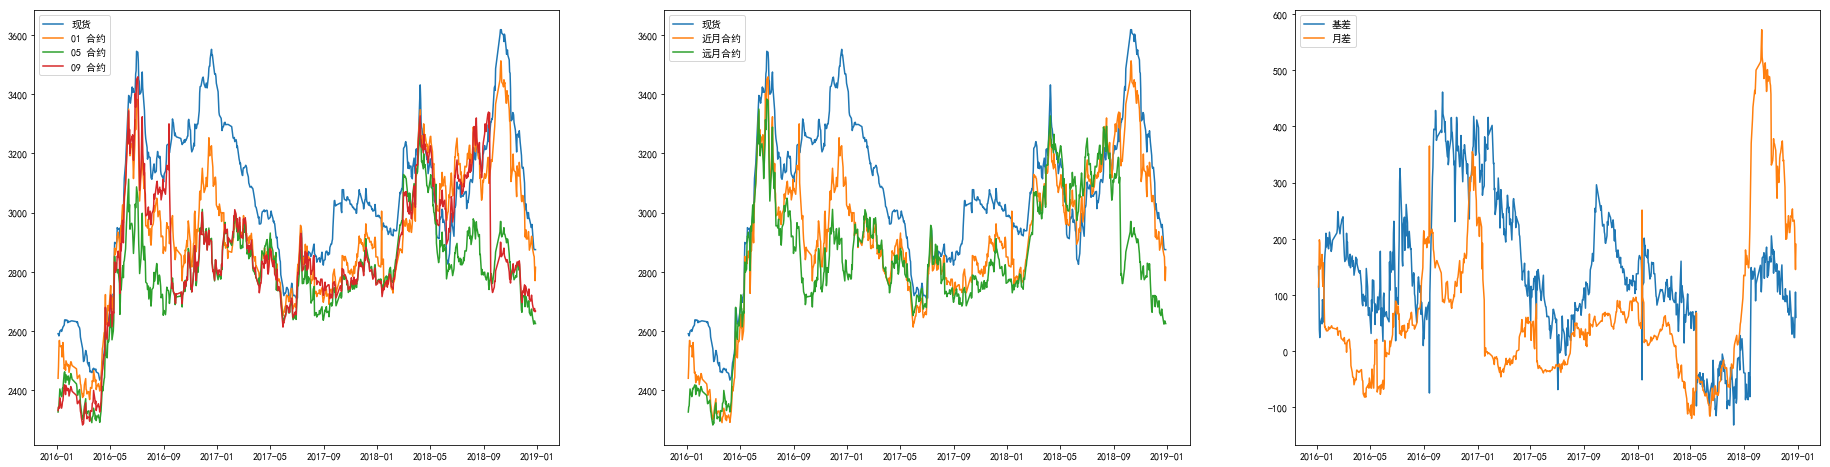

In [3]:
# 基差和期限价差

# 以主力合约作为近月合约，月份大于近月合约月份且在 1,5,9 合约中的最小月份合约作为远月合约
# iTargetIDs = [Symbol+iID+"."+Exchg for iID in ["01M", "05M", "09M"]]
# NPrice = CCPrice.loc[:, :, MID]
# FPrice = NPrice.copy()
# for i, iDT in enumerate(DTs):
#     iMID = ContractMapping[MID].iloc[i]
#     iIDs = ContractMapping.iloc[i].loc[iTargetIDs]
#     iIDs = iIDs[iIDs>iMID]
#     iFID = iIDs[iIDs==iIDs.min()].index[0]
#     FPrice.iloc[i, :] = CCPrice.loc[:, iDT, iFID]

# 以 1,5,9 合约中最近的合约作为近月合约，次近的合约作为远月合约
iTargetIDs = [Symbol+iID+"."+Exchg for iID in ["01M", "05M", "09M"]]
NPrice = pd.DataFrame(np.nan, index=DTs, columns=CCPrice.items)
FPrice = NPrice.copy()
for i, iDT in enumerate(DTs):
    iMID = ContractMapping[MID].iloc[i]
    iIDs = ContractMapping.iloc[i].loc[iTargetIDs]
    iNID = iIDs[iIDs==iIDs.min()].index[0]
    iIDs = iIDs[iIDs>iIDs.min()]
    iFID = iIDs[iIDs==iIDs.min()].index[0]
    NPrice.iloc[i, :] = CCPrice.loc[:, iDT, iNID]
    FPrice.iloc[i, :] = CCPrice.loc[:, iDT, iFID]

# 基差和月差
PriceFactor = "收盘价"
Basis = SpotPrice - NPrice[PriceFactor]
CalendarSpread = NPrice[PriceFactor] - FPrice[PriceFactor]

Fig, Axes = plt.subplots(1, 3, figsize=(32, 8))
Axes[0].plot(DTs, SpotPrice.values, label="现货")
Axes[0].plot(DTs, CCPrice.loc[PriceFactor, :, ("%s01M.%s" % (Symbol, Exchg))].values, label="01 合约")
Axes[0].plot(DTs, CCPrice.loc[PriceFactor, :, ("%s05M.%s" % (Symbol, Exchg))].values, label="05 合约")
Axes[0].plot(DTs, CCPrice.loc[PriceFactor, :, ("%s09M.%s" % (Symbol, Exchg))].values, label="09 合约")
Axes[0].legend(loc='best');
Axes[1].plot(DTs, SpotPrice.values, label="现货")
Axes[1].plot(DTs, NPrice[PriceFactor].values, label="近月合约")
Axes[1].plot(DTs, FPrice[PriceFactor].values, label="远月合约")
Axes[1].legend(loc='best');
Axes[2].plot(Basis, label="基差")
Axes[2].plot(CalendarSpread, label="月差")
Axes[2].legend(loc='best');

## 交割延期理论

最早由 Keynes 和 Hicks 在 20 世纪 30 年代提出的, 即生产和消费(包括使用商品作为投入品的制造商的需求活动)的基础条件是, 生产者必须比消费者向前看得远的多, 套期保值者作为一个整体倾向于空头, 为了劝说投机者持有多头的态度, 必须给予一个正数的风险补偿, 即"卖方付给买方的正常交割延期费用", 由于近月合约更贴近于现货价格, 所以远月套保价格应该较低. 因而在正常情况下, 远期价格应该低于近期价格(远月贴水). 

此理论潜在假设是投机者是有理性的, 即他们根据各种有用的信息对预期期货价格进行分析. 虽然理性的投机者偶尔会犯错误, 但作为整体, 他们对信息的分析是有效的. 因此, 在合约到期前, 每一期货价格都会趋向于提高到与相应的现货价格相等为止. 此理论提出后, 不断有学者对其验证, 发现了市场上存在一些矛盾, 从长期的结论来看, 交割延期费理论对某些特定的市场在特定条件下是有效的, 但是作为对一般商品行为的解释是不充分的.


## 套期保值压力理论

期货市场的参与者可以分为套期保值者和投机者，前者的目的在于锁定自身收益，对冲未来标的价格变动的风险，愿意支付风险补偿来转移风险；投机者是风险偏好者，愿意承担风险但需要风险补偿。

套期保值压力理论认为，正是这种风险的转移导致了现货市场与期货市场的基差。具体解释如下：如果套保者是一个生产商，他希望对冲掉未来产品价格下降而带来的风险，卖出期货合约，此时持有空头的净头寸。为了将风险转移宁愿支付风险补偿，所以期货合约价格将低于基于现货价格的未来期望价格。随着期货合约的到期，期货价格不断上升，趋于现货的期望价格，持有多头净头寸的投机者获得风险补偿；如果套保者是希望锁定原材料成本的加工商，持有净的多头头寸。为了对冲掉原材料价格上涨的风险， 愿意支付高于现货未来期望的价格来购买合约。因此，期货价格在到期的过程中下降，持有空头头寸的投机者获得风险补偿。

## 仓储价格理论(Price of Storage Theory) 

又称仓储供应理论(Supply of Storage Theory)或仓储成本理论(Cost-of-Carry theory). 卡尔多(1939)首次提出了便利收益(Convenience Yield)在仓储决定中的重要性. 后来 Brennan 等人沿着这个方向对仓储价格理论进行了完善. 仓储价格理论论证了期货价格, 现货价格, 仓储费和仓储量之间的密切关系. 其主要观点是仓储的边际报酬即基差等于边际净仓储成本加上风险报酬, 减去便利收益. 

**便利收益** 就是持有存货所带来的除了价格上涨的期望收益. 制造商和中间商获得便利收益与社会的库存水平成反比, 社会的库存水平越高, 他们所获得的便利收益就越小, 现货的便利收益的降低将会影响现货以及近月合约的价格, 从而使得近月更容易出现贴水状态, 反之当社会库存水平较低时, 便利收益越大, 远月更容易出现贴水的情况. 仓储价格理论相对于交割延期理论更好的解释了期限结构, 说明了期货价格对现货供求调节的原因, 期货价格能够调节现货供求, 这种调节功能是通过仓储过程实现的。

## 展期收益率(Roll Yield)

不同到期日的期货价格不同意味着即便现货价格一直保持不变，期货头寸也会有非零收益率（到期时期货价格强制收敛到现货价格）。这个收益率即为 **展期收益率**。在连续情形下，展期收益率定义为期货价格关于到期时间的导数的相反数：
$$
\gamma_t = -\frac{\partial(\log F(t,T))}{\partial T}
$$
其中，$t$ 为当前时点，$T$ 为到期时点。当处于远月贴水状态下，近月合约比远月合约价格高，展期收益率为正；当处于近月贴水状态下，近月合约比远月合约价格低，展期收益率为负。

期货的总收益率可以分解成现货收益率（Spot Return）和展期收益率两部分（\cite{Chan:2013}），假设期货价格为：
$$
F(t,T) = S(t)e^{\gamma(t-T)}
$$
其中，$S(t)$ 是现货价格，$\gamma$ 是展期收益率，这里假设其为常数。假设现货价格服从：
$$
S(t) = S_0e^{\alpha t}
$$
其中，$\alpha$ 为现货收益率，假设也为常数。从而有：
$$
F(t,T) = S_0e^{\alpha t+\gamma(t-T)}
$$
则期货的总收益率为：
$$
\frac{\partial(\log F(t,T))}{\partial t} = \alpha + \gamma
$$
从而，总收益率 = 现货收益率 + 展期收益率。

In [ ]:
# 估计现货收益率
if SpotID is not None:
    RegRslt = sm.OLS(np.log(SpotPrice.values), sm.add_constant(np.arange(SpotPrice.shape[0]), prepend=False), missing="drop").fit()
    SpotReturn = RegRslt.params[0] * SpotPrice.shape[0] / (SpotPrice.index[-1] - SpotPrice.index[0]).days * 365
    print("Average Annualized Spot Return: %.2f%%" % (SpotReturn * 100, ))

    Fig, Axes = plt.subplots(figsize=(16, 8))
    Axes.set_xlabel("Time: t")
    Axes.set_ylabel("log(Spot Price)")
    Axes.scatter(SpotPrice.index, np.log(SpotPrice.values))
    Axes.plot(SpotPrice.index, RegRslt.params[0] * np.arange(SpotPrice.shape[0]) + RegRslt.params[1], color="r", linewidth=2);

离散情形下可以用两个合约来估计展期收益率：
\begin{equation}\label{eq:roll-yield}
\gamma_t = \frac{\log F(t,T_N)-\log F(t,T_F)}{T_F-T_N}
\end{equation}
其中, $F(t,T_N)$ 是近月合约(或者现货)在 t 时刻的价格, $T_N$ 是近月合约(现货为 t)的到期时间, $F(t,T_F)$ 是远月合约在 t 时刻的价格, $T_F$ 是远月合约的到期时间. 如果时间的度量以年为单位, 则计算的是年化的展期收益率。

In [ ]:
# 使用主力合约和次主力合约估计展期收益率

# # 获取连续合约的月合约到期日
# MonthIDs = ContractMapping.values.flatten()
# MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
# LastTradeDate = WDB.getTable("中国期货基本资料").readData(factor_names=["最后交易日期"], ids=MonthIDs, dts=[EndDT]).iloc[0, 0]
# LastTradeDate = pd.DataFrame([ContractMapping[iID].apply(lambda x: LastTradeDate[x] if pd.notnull(x) else None) for iID in CCIDs],index=CCIDs).T
# ExpirationDays = pd.DataFrame(np.nan, index=LastTradeDate.index, columns=LastTradeDate.columns)
# for i, iDT in enumerate(DTs): ExpirationDays.iloc[i] = LastTradeDate.iloc[i].apply(lambda x: (dt.datetime.strptime(x, "%Y%m%d") - iDT).days)

Fun = lambda x: (dt.datetime.strptime(x.iloc[0], "%Y%m%d") - dt.datetime.strptime(x.iloc[1], "%Y%m%d")).days / 365 if (pd.notnull(x.iloc[0]) and pd.notnull(x.iloc[1])) else np.nan
TimeDelta = LastTradeDate.loc[:, [MID, SID]].apply(Fun, axis=1)
RollYield_MS = np.diff(np.log(MSPrice), axis=1)[:, 0] / TimeDelta
print("Average Annualized Roll Return: %.2f%%" % (RollYield_MS.mean()*100, ), end="\n\n")

# 平稳性检验
# ADF 检验
ADFTest = sm.tsa.stattools.adfuller(RollYield_MS[pd.notnull(RollYield_MS)].values, regression='c', autolag="BIC")
print("Roll Yield ADF Test",
      ("Statistic : %f" % ADFTest[0]), 
      ("pvalue : %f" % ADFTest[1]), 
      ("usedlag : %d" % ADFTest[2]), sep="\n")

Fig, Axes = plt.subplots(2, 2, figsize=(32, 16))
Axes[0, 0].scatter(ExpirationDays.iloc[:, 0].values / 365, np.log(MSPrice.iloc[:, 0].values))
Axes[0, 0].set_xlabel("到期时间")
Axes[0, 0].set_ylabel("对数价格");
Axes[0, 1].plot(RollYield_MS)
Axes[0, 1].plot(RollYield_MS.index, np.zeros(RollYield_MS.shape[0]), color="r")
Axes[0, 1].set_title("Roll Return")
sm.graphics.tsa.plot_acf(RollYield_MS[pd.notnull(RollYield_MS)].values, lags=60, ax=Axes[1, 0])
sm.graphics.tsa.plot_pacf(RollYield_MS[pd.notnull(RollYield_MS)].values, lags=60, ax=Axes[1, 1]);

也可以使用多个合约来估计展期收益率，即在时点 t 用所有期货合约（包括现货）的对数价格关于到期时间 T（现货为 0）进行截面回归：
$$
\log F(t,T) = \gamma_0 + \gamma\cdot T + \varepsilon
$$
回归系数 $\gamma$ 即为展期收益率的估计值。

In [ ]:
# 使用所有合约回归来估计展期收益率
RollYield_OLS = np.full(CCPrice.shape[0], np.nan)
RegStats = pd.DataFrame(np.nan, index=CCPrice.index, columns=["R-squared", "Adj. R-squared", "F-statistic", "t-statistic"])
for i, iDT in enumerate(tqdm_notebook(CCPrice.index, desc="日期 loop")):
    iX = ExpirationDays.iloc[i, 2:].values
    iY = np.log(CCPrice.iloc[i].values)
    if SpotID is not None:
        iX = np.r_[0, iX]
        iY = np.r_[np.log(SpotPrice.iloc[i]), iY]
    iRegRslt = sm.OLS(iY, sm.add_constant(iX, prepend=False), missing="drop").fit()
    RollYield_OLS[i] = - iRegRslt.params[0]
    RegStats.iloc[i] = (iRegRslt.rsquared, iRegRslt.rsquared_adj, iRegRslt.fvalue, iRegRslt.tvalues[0])
RollYield_OLS = pd.Series(RollYield_OLS, index=CCPrice.index)
print("Average Annualized Roll Return: %.2f%%" % (RollYield_OLS.mean()*100, ))

# 平稳性检验
# ADF 检验
ADFTest = sm.tsa.stattools.adfuller(RollYield_OLS[pd.notnull(RollYield_OLS)].values, regression='c', autolag="BIC")
print(("Roll Yield ADF Test Statistic : %f" % ADFTest[0]), 
      ("pvalue : %f" % ADFTest[1]), 
      ("usedlag : %d" % ADFTest[2]), sep="\n")

Fig, Axes = plt.subplots(2, 3, figsize=(32, 16))
Axes[0, 0].plot(RollYield_OLS)
Axes[0, 0].plot(RollYield_OLS.index, np.zeros(RollYield_OLS.shape[0]), color="r")
Axes[0, 0].set_title("Roll Return")
sm.graphics.tsa.plot_acf(RollYield_OLS[pd.notnull(RollYield_OLS)].values, lags=60, ax=Axes[0, 1])
sm.graphics.tsa.plot_pacf(RollYield_OLS[pd.notnull(RollYield_OLS)].values, lags=60, ax=Axes[0, 2])
Axes[1, 0].plot(RegStats["R-squared"])
Axes[1, 0].set_title("R-squared")
Axes[1, 1].plot(RegStats["t-statistic"])
Axes[1, 1].set_title("t-statistic")
Axes[1, 2].scatter(iX, iY)
Axes[1, 2].plot(iX, iRegRslt.params[0]*iX+iRegRslt.params[1], color="r", linewidth=2)
Axes[1, 2].set_xlabel("到期时间")
Axes[1, 2].set_ylabel("对数价格");

展期收益率去除了期限价差的时间因素，方便各个品种的比较，且当展期收益率为正时表明此时远月贴水，反之近月贴水，且其绝对值越大，贴水程度越高。

展期收益率的符号不会频繁的变化，这使得期货合约会长时间的保持在远月贴水或者近月贴水的状态。相比之下，现货收益率的波动性较大，如果平均来看展期收益率在总收益率中占据主导，则会导致期货收益率呈现一定的序列相关性。（\cite{Chan:2013}）

In [ ]:
# 展期收益率的平稳性检验
# ADF 检验
RollYieldADFTest = sm.tsa.stattools.adfuller(RollYield.values, regression='c', autolag="BIC")
print(("Roll Yield ADF Test Statistic : %f" % RollYieldADFTest[0]), 
      ("pvalue : %f" % RollYieldADFTest[1]), 
      ("usedlag : %d" % RollYieldADFTest[2]), sep="\n")

# Hurst 指数
from QuantStudio.Tools.MathFun import genHurstExp
RollYieldHurstExp, _ = genHurstExp(RollYield.values)
print("Roll Yield Hurst Exponent : %f" % RollYieldHurstExp)

# ACF, PACF
DiffRollYield = RollYield.diff().iloc[1:]
Fig, Axes = plt.subplots(2, 3, figsize=(32, 16))
Axes[0, 0].plot(RollYield)
Axes[0, 0].set_title("Roll Yield")
sm.graphics.tsa.plot_acf(RollYield, lags=60, ax=Axes[0, 1])
sm.graphics.tsa.plot_pacf(RollYield, lags=60, ax=Axes[0, 2])
Axes[1, 0].plot(DiffRollYield)
Axes[1, 0].set_title("Diff. of Roll Yield")
sm.graphics.tsa.plot_acf(DiffRollYield, lags=60, ax=Axes[1, 1])
sm.graphics.tsa.plot_pacf(DiffRollYield, lags=60, ax=Axes[1, 2]);

## 期限结构和基本面的关系

根据仓储理论，通过市场的期限结构便可反推出市场的供需情况：
* 正向市场（Contango）结构一般反应了当下商品供应过剩，所以有多余的商品可以储存起来，作为远期的需求，多余商品的存储需要一定的成本，所以从理论上来讲，近月合约价格应该等于现货价格加上持有成本，远月合约价格应该等于近月价格加持有成本或者说现货价格加一个更大的持有成本。当然这里面还有预期的作用，由于对未来存在较为乐观的预期，预期未来这种供过于求的情况会改变，所以远月价格最高。
* 反向市场（Backwardation）结构一般反应了当下商品市场上供求关系紧张，所以现货价格比较高，由于供求关系紧张，也就没有多余的货进行存储，所以远期合约也就没有了所谓的持仓成本的那个逻辑。由于供求关系紧张，现货价格较高，产品的利润丰厚，所以会吸引更多的生产者进来，从而随着随着生产者的增加，产品供应增加，供求关系在预期会得到改善，所以远期价格比较低，但是这个过程需要一定时间，时间越久，产品供应增加的预期越强烈，所以越是远月，价格越低。

除了上述两种最为常见的市场结构之外，有时候市场也会出现两种比较畸形的期限结构：
* 凹型期限结构：现货价格高于近月价格，而近月价格又低于远月价格。出现这种情况的可能性原因一种是在供求关系不发生变化的情况下，交易所对商品的交割品质进行修订，交割品质更加严格了，从而导致远月合约价格出现了异常。
* 凸型期限结构：现货价格低于近月价格，而近月价格又高于远月价格。这种情况下，可能并不是市场供需关系的长期变化，而是由于出现了某种意外冲击，导致远月价格出现异常，最常见的就是制度冲击。例如苹果期货，市场本来是正常的正向市场，但是由于 AP1901 合约修改了交割品质的要求，结果导致远月价格大跌，从而形成了凸型市场结构。

通过对历史的观察，[1] 中总结了一些规律：
1. 当一个品种的价格处于底部区域，往往会呈现出 Contango 结构；
2. 当一个品种的价格处于顶部区域，往往会呈现出 Backwardation 结构；
3. 当一个品种的期限结构在低位从 Contango 结构变为 Backwardation 结构，往往暗示着这个品种的基本面发生了转折，从空头市场变为多头市场；
4. 当一个品种的期限结构在高位从 Backwardation 结构变为 Contango 结构，往往暗示着这个品种的基本面发生了转折，从多头市场变为空头市场；

由以上 4 点可以推理得出，任何一个品种发生历史级别的大行情的时候，现货的涨跌幅度远远大于期货的涨跌幅度。当一个品种的期限结构没有发生根本性变化，那就是小的基本面变化；当一个品种的期限结构如果发生了根本性变化，那就是大的基本面变化。小基本面的变化反映为一些波动性的行情；大的基本面变化往往是一个长期趋势性行情。

# 期现套利

现货价格是产业客户在现货市场进行商品买卖交易的价格，是当下的价格。期货价格是未来某一时点的价格，是预期的价格。

正常情况下基差会处于某个区间范围之内，这个区间就叫做无套利区间。而当基差偏离了无套利区间则产生了套利机会。按照持有成本理论，期货价格与现货价格之间的价差（负基差）应该等于该商品的持有成本，持有成本包括资金成本和交割成本等。持有成本正是这个无风险套利区间的上限。当期货价格与现货价格之间的价差超过了这个上限，产业客户就可以做空商品，锁定利润：利润 = 期现价差 - 持有成本。

商品期货正向期现套利的持有成本主要包括：
持有成本 = 交易手续费 + 交割手续费 + 运输费 + 入库费 + 检验费 + 仓单升贴水 + 仓储费 + 增值税 + 资金占用费

受当下基本面因素的影响，期货价格与现货价格发生偏离很正常也很常见。随着时间推移，“未来”成为“当下”，价格也将趋于一致，二者从偏离到趋于一致这个过程就是 **基差回归** 过程，如果排除逼仓的特殊情况，那么基差回归就是必然的，否则产业客户的套利行为就会促使期现价格趋于一致直至套利机会消失。基差回归一般有两种方式，即现货向期货靠拢和期货向现货靠拢，作为不能参与交割的投机交易，只能靠后一种回归赚钱。

期现价差偏离的原因：
1. 突发重大事件或消息。由于期货和现货对消息的敏感程度不同，从而对消息的反应程度会存在差异。一般情况下，期货市场比现货市场反映更加迅速和强烈，这是由两个市场的特点决定的，因为现货市场购销模式下的价格在一定时间内相对具有一定的刚性，所以反映不如期货那么大。但这不是绝对的，因为期货是有涨跌停限制，而现货市场上没有。
2. 现货供需格局失衡。由于基本面的改变，导致现货供需失衡，从而导致期货市场上产生强烈的看涨或看跌预期，尤其是在大牛市或大熊市时，往往容易出现基差与持有成本之间出现较大的偏离。
3. 逼仓行情的出现。当逼仓行情出现时，通常会导致期货价格脱离供需关系，从而引发单边行情，使得期货和现货的正常价格关联被破坏，从而创造了套利的机会。


# 跨期套利

从期现套利的角度来讲：期货价格 <= 现货价格 + 持有成本

从跨期套利角度来讲：远月合约价格 <= 近月合约价格 + 持有成本

套利交易的方向：
* **正套**：买近月合约，卖远月合约，即做多价差。
* **反套**：卖近月合约，买远月合约，即做空价差。

**跨期价差偏离的原因**：
1. 周期性因素：农产品通常具有较强的季节性周期，工业品也有生产和消费的周期。比如正向市场结构中，在供应旺季或消费淡季时，近月合约面临的压力往往更大一些，从而与远月合约之间的价差容易被拉大；在供应淡季或消费旺季时，近月合约面临的价格提升动力更大一些，从而与远月合约之间的价差容易被缩小。
2. 流动性因素：主力合约与非主力合约持仓量不同，在移仓换月时，有时候市场流动性不够好，也可能会引起合约之间价差的不合理波动。
3. 波动性因素：不同月份合约之间的波动性本身各不相同，近月合约的波动性通常更加剧烈一些，主要是因为交易者在近月合约上交易更加频繁导致的。比如正向市场结构中，在较大的单边下跌行情下，近月合约由于波动性更大，所以跌幅可能会更深一些，从而使得与远月合约之间的价差容易被拉大。
4. 交割规则：交易所的一些规定往往会对价差有比较大的影响，比如品种的仓单有效期以及交割品质。无法转抛以及劣质替代品交割都会导致近月合约偏弱，从而影响跨期价差。
5. 事件冲击。一般情况下，短暂的事件冲击对持仓量比较大的近月合约影响比较大，对远月影响较小，也会导致价差发生变化。

**期货合约主要矛盾的变化**：
任何一个期货合约从最初上市到最终进入交割月，在不同的时间段内，其主要矛盾是不同的，或者说驱动逻辑是不同的。因此需要对不同月份的合约进行区别对待，根据其距离交割月的远近，选择不同的交易逻辑。[1] 中把一个期货合约距离交割月的远近分为三个主要阶段：
* 远期合约：距离交割月在 2 个月以上，离交割月较远。驱动的核心逻辑是成本以及库存的变化趋势。所以要关注的因素主要是商品的成本利润情况以及库存的变化趋势。
* 近期合约：距离交割月在 1-2 个月之间，离交割月较近。驱动的核心逻辑是基差的收敛与库存绝对水平的高低。所以主要关注基差的变化与库存的绝对量有多少。
* 即期合约：距离交割月在 1 个月之内，即将进入交割月。驱动的核心逻辑是仓单的交割与基差的修复。所以主要关注仓单的变化与基差的修复情况。

## 交易逻辑

**基差逻辑**

对于近月合约来说，主要矛盾是基差修复，而远月合约更多的是受预期的影响，所以近月合约贴水时，通常适合做正套；相反，如果近月合约升水时，通常适合做反套。这种跨期套利的逻辑，本质上和单边交易中参与基差修复行情是一样的。从基差的交易逻辑来做跨期套利：贴水做正套，升水做反套。

**仓单逻辑**

因为做套利往往需要持有一定的时间，有时候需要持有到合约成为即期合约，在合约成为即期合约时，产业客户交不交货、接不接货对期货价格的影响是非常大的，而仓单的变化情况反应的是产业客户的行为：
* 如果产业客户打算卖出套保，那么仓单就会大量生成，对于近月来说，多头面对巨量的仓单交割压力，往往选择把多头头寸转移到远月合约，从而导致近月合约由于多头主动减仓而下跌，远月合约由于多头主动移仓而上涨，从而有利于形成正向的市场结构。在这种情况下就适合去做反套。
* 如果产业客户打算买入套保，那么近月合约的持仓量往往会很大，相反仓单的数量却非常少，空头面对如此巨量的接货资金，由于没货交割，往往选择把空头头寸转移到远月合约，从而导致近月合约由于空头主动减仓而上涨，远月合约由于空头主动移仓而下跌，从而有利于形成反向的市场结构。这种情况下适合做正套。

从仓单的交易逻辑来做跨期套利：巨量仓单做反套，少量仓单做正套。

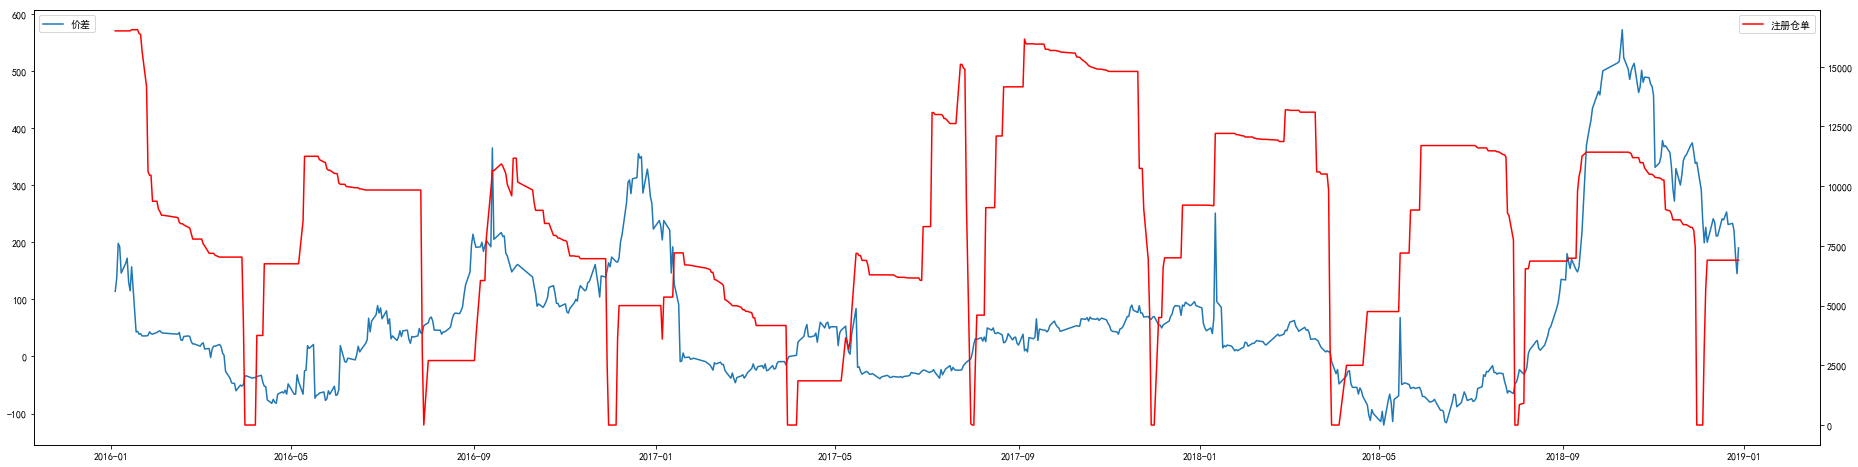

In [4]:
# 期货仓单
TSDB = QS.FactorDB.TushareDB()
TSDB.connect()
RegistedInstock = TSDB.getTable("仓单日报").readData(factor_names=["今日仓单量"], ids=["M"], dts=DTs, args={"算子":np.nansum}).iloc[0,:,0].fillna(method="ffill")

Fig, Axes = plt.subplots(1, 1, figsize=(32, 8))
Axes.plot(DTs, CalendarSpread.values, label="价差")
RAxis = Axes.twinx()
RAxis.plot(DTs, RegistedInstock.values, color='r', label="注册仓单")
Axes.legend(loc='upper left')
RAxis.legend(loc='upper right');

In [10]:
# 仓单变化与月差变化的相关性

np.corrcoef(np.diff(RegistedInstock.values), np.diff(CalendarSpread.values))[0,1]

0.04582896973155692

**库存逻辑**

在高库存的情况下，现货市场供应充足，现货价格相对疲软，从而导致近月合约价格往往较弱，所以更加利于做反套，市场结构通常是正向的；相反，在低库存的情况下，现货市场供应紧张，现货价格相对坚挺，从而导致近月价格往往强势，所以更加利于做正套，市场结构通常是反向的。从库存的交易逻辑来做跨期套利：低库存做正套，高库存做反套。

**成本逻辑**

最原始的跨期套利就是基于成本逻辑，主要是持仓成本理论，由于持仓成本的缘故，远月合约要高于近月合约，如果远月价格减去近月价格低于持仓陈本，就存在了做反套的机会；如果远月价格减去近月价格远高于持仓成本，就存在无风险的正套机会。这是最初的成本套利逻辑。后来成本逻辑也经历了一定的发展，主要看进口成本，像矿石、豆粕、菜油、棕榈油等这些品种主要看进口原料的成本，有对应的船期和升贴水报价，如果进口成本是反向市场，在正常的供求状态下，国内对应的商品也应该是反向市场，所以应当顺着进口成本的方向进行跨期套利。然而，一方面很难估计出产业客户准确的持仓成本，另一方面对于一些商品的进口成本获取上也相对麻烦一些，所以很难去做成本逻辑的跨期套利。

## 不同市场结构下的交易

单纯从期限结构自身来看，正向市场结构利于做反套，尤其是结合仓单有效期强制注销的合约，当有大量仓单生成的时候，做反套效果往往比较好；反向市场结构利于做正套，尤其是结合临近交割时虚实盘比比较大的时候，做正套效果往往比较好。

**正向市场的正向套利**

当某个品种处于正向市场时，如果远月价格远远高于近月价格，二者之间的价差超过了现货贸易商的持仓成本，就会出现无风险套利的机会。这个时候是进行正套的最佳时机。当然，不同贸易企业的持仓成本是不一样的，产业客户可以自己计算自己的持仓成本，然后以交割为底线，进行期现套利或者是跨期套利。对于投机类交易者来说，只能是关注一下历史价差情况，在正向市场中，当价差位于历史高位或者超过历史极值时，都是不错的正套机会，几乎是无风险套利，亏损的可能性非常低。特点：正向市场的正向套利对贸易商来说是无风险套利，对投机客户来说是风险最低的一种套利。


**反向市场的正向套利**

在反向市场结构下，最好的机会产生于未来预期变得悲观时，由于近月合约的核心矛盾是基差修复，远月合约的核心矛盾是预期变化，所以这个时候选择正套：
* 在行情上涨时，近月合约处于基差修复的目的，会快速上涨，而远月预期悲观，上涨幅度通常不及近月；
* 在行情下跌时，近月由于贴水，下跌幅度有限，而远月由于预期悲观，暂时没有基差修复的压力，所以下跌幅度更大。

另外，由于这种市场结构背后往往反映的是现货市场供求关系紧张，所以库存一般比较低、仓单通常也比较少，所以近月合约存在很大的逼仓可能性。

反向市场的正向套利买的高价合约，卖的是低价合约，这与通常所理解的低买高卖才能赚钱的思维是不一样的。需要注意的是，这种正套有两个重要的问题：
* 近月合约的天花板问题，由于近月合约的价格基本上不可能变成升水现货价格，所以当近月合约贴水幅度越来越小，基差修复差不多了，基本上就涨不上去了，而远月合约由于贴水幅度更多，所以在近月涨不动的时候，远月合约会比近月合约涨得更多。这个时候市场就开始走反套逻辑。
* 近月合约移仓问题，当近月合约面临交割，近月多头开始纷纷移仓，这个时候近月合约就会出现多头主动减仓，远月合约就会出现多头主动加仓，所以近月和远月又一次会出现强弱转化。

综上所述，做反向市场的正向套利时，在距离交割月较远的时候，如果近月合约基本上平水了，那么就先要平仓兑现利润，因为接下来市场一般要走反套逻辑，直到近月合约又出现一定幅度的贴水，然后才继续走正套逻辑。如果在距离交割月较近的时候，出现了近月合约大幅减仓，价格上涨幅度不大，则可以断定是多头主动减仓，相反，如果近月合约大幅减仓同时大幅上涨，那么说明是空头主动移仓，空头主动移仓，有利于正套，多头主动移仓，则会走出反套逻辑，如果发现大幅减仓，且价格上涨无力，这个时候正套也要平仓兑现利润。

在低库存+深贴水+高利润的情况下，适合采取反向市场正向套利的交易策略，做跨期套利能否赚钱的一个最重要的原因就是现货是否坚挺，反向市场正向套利的逻辑是这样演绎的：

预期现货稳定或坚挺——>反向市场做正套——>现货稳定，近月合约期货上涨修复——>利润过高，不可持续，预期悲观，远月上涨乏力，下跌动能更大一些——>由于现货稳定，随着交割日期临近，空头率先移仓——>近月空头主动减仓上涨，远月空头主动加仓打压——>反向市场正套价差拉大，套利盈利——>多头大幅获利，多头在空头认输移仓之后才移仓——>近月多头减仓下跌，远月多头主动增仓上涨——>反向市场正套价差缩小，利润回撤。

由此可以看出，多空双方的分歧在于多头认为低库存会使得现货坚挺，空头认为高利润会使得现货松动，随着交割日的临近，现货的真实情况影响了多空双方的移仓先后顺序，现货稳定或坚挺会导致空头认输，率先移仓，从而正套逻辑开始赚钱。然而，这并不代表着反向市场做正向套利就一定是赚钱的，最核心的一点就是现货的情况，现货是会继续保持坚挺状态，还是会因为期货的下跌而被击穿，套利结果就不一样。


**正向市场的反向套利**

在正向市场结构当中，最好的机会产生于未来预期相对较好时，同样是基于近月合约矛盾的核心是基差修复，远月合约的核心是预期变化：
* 在行情上涨时，近月合约由于升水，上涨幅度有限，而远月合约无需进行基差修复，所以上涨幅度较大；
* 在行情下跌时，近月合约由于需要修复基差，期货会迅速向现货修复，而远月合约由于预期乐观，没有基差修复的需求，所以下跌幅度会小一些。

这种市场结构本身反应了商品供应过剩，所以库存会比较大，仓单压力也比较重，所以近月合约一般都会比较弱。

这个套利的不足之处在于，盈利空间有限，因为一旦远月合约和近月合约之间的价差拉大，就会给产业客户提供正向市场正向套利的机会，即无风险套利的机会。

平仓的时机一方面主要是看近月合约是否依然有下跌空间，主要看升水幅度；另一方面从多头和空头移仓的角度去看，如果多头先移仓，那么利于反套，如果空头先移仓，那么反套也需要平仓兑现利润。


**反向市场的反向套利**

在反向市场结构当中，预期未来商品的供需格局会发生变化，这个时候采取反套。近月贴水空近月不如直接多远月。在直接多远月的情况下，如果现货市场坚挺或者市场结构发生方向性变化，那么将会盈利巨大。当市场预期悲观，远月合约深度贴水，当近月合约退市时价格依然坚挺，那么远月合约向近月修复的概率就比较大，盈利空间也相对大一些。反向市场走出反套的逻辑，最根本的原因是期货的下跌把现货击穿，多头认输率先移仓：

预期现货稳定或坚挺——>反向市场做正套——>现货稳定，近月合约期货上涨修复——>利润过高，不可持续，预期悲观，远月上涨乏力，下跌动能更大一些——>由于现货大幅下跌，随着交割日的临近，多头率先移仓——>近月多头主动减仓下跌，远月多头主动增仓坚挺——>反向市场正套价差缩小，套利亏损——>空头大幅获利，空头在多头认输之后才开始移仓——>近月空头减仓上涨，远月空头加仓上涨乏力——>反向市场正套价差拉大，亏损减少。

基于低库存的逻辑判断现货会坚挺，要关注低库存的客观条件是否发生变化，还需关注现货会坚挺的预期结果是否得到证实；基于高利润的逻辑判断现货会松动，要关注高利润的客观条件是否发生变化，还需要关注现货会松动的预期结果是否得到证实。

总之，反向市场的反向套利容易失败。

## 利用仓单有效期的规定做反套

交易所对仓单有效期的规定会导致近月接货不一定能够转抛到远月。例如橡胶 09-01 价差历来比较大，因为 9 月合约的胶是老胶，无法转抛到来年 1 月，所以在无法转抛的情况下，持有成本理论往往是行不通的。

正向市场的结构下，说明商品当下供过于求，库存较高，通常情况下，高库存都会对应较大的仓单，所以说正向市场上的品种在巨量仓单的作用下，往往面临着较大的交割压力。这是由于现货市场供过于求，价格较低，所以卖方更希望通过期货市场来抛货交割。作为接货的买方来说，现货市场供过于求，没有必要从价格更高的期货市场去接货，所以如果卖方希望能够顺利从期货市场把货出售，期货的价格要做足够低，直到低于现货市场的价格，买方才有接货的意愿。所以很多高库存的品种，基本上都是走这种巨量交割逻辑，从最初的期货升水，到后来的期现平水，再到最终的贴水交割。但是这里面有一个问题，就是多头接货的意愿问题。有时候多头接货可以直接在期货市场上转抛，在这种情况下多头接货的意愿会大一些。如果多头接货之后无法继续转抛，只能在现货市场出售，那么多头接货的意愿就会弱一些，多头的接货意愿越弱，空头的交货意愿越强，那么这个品种未来贴水交割的幅度也就越大，正向市场做反套的盈利空间就更大一些。而决定了多头接货能否继续转抛的关键问题就是交易所对仓单有效期的规定。

相关品种仓单有效期的规定

大商所的规定
* 豆一：3 月最后一个工作日
* 豆二：3 月最后一个工作日
* 玉米：3 月最后一个工作日
* LLDPE：3 月最后一个工作日
* PVC：3 月最后一个工作日
* 豆粕：3 月、7 月、11 月最后一个工作日
* 豆油：12 月最后一个工作日
* 棕榈油：每月最后交割日后 3 日内必须注销
* 焦炭：3 月最后一个工作日
* 焦煤：每月最后交割日后 3 日内必须注销
* 铁矿石：3 月最后一个工作日
* PP：3 月最后一个工作日
* 玉米淀粉：3 月、7 月、11 月最后一个交易日前注销
* 鸡蛋：每月最后交割日后 1 个工作日内必须注销

郑商所的规定
* 棉花：N+2 年 3 月最后一个工作日
* 白糖：N 制糖年度（每年 10 月 1 日至次年 9 月 30 日）生产的白糖所注册的标准仓单有效期为该制糖年度结束后当年 11 月份最后一个工作日
* 菜籽油：N 年 6 月 1 日起注册的仓单有效期为 N+1 年 5 月最后一个工作日
* PTA：9 月第 12 个交易日前注册的仓单，在当月第 15 个交易日前注销
* 甲醇：5 月、11 月第 12 个交易日前注册的仓单，当月第 15 个交易日前注销
* 玻璃：5 月、11 月第 12 个交易日前注册的仓单，当月第 15 个交易日前注销
* 菜粕：每年 3 月、7 月、11 月第 12 个交易日之前注册的仓单，当月第 15 个交易日前注销
* 动力煤：5 月、11 月第 7 个交易日前注册的仓单，在当月第 10 个交易日前注销
* 苹果：5 月、7 月第 12 个交易日前注册的仓单，当月第 15 个交易日前注销
* 锰硅：10 月第 12 个交易日前注册的仓单，当月第 15 个交易日前注销
* 硅铁：2 月、6 月、10 月第 12 个交易日前注册的仓单，当月第 15 个交易日前注销

上期所的规定
* 橡胶：生产年份次年 11 月强制注销
* 沥青：9 月 15 日前生成的仓单在 10 月最后一个工作日前注销
* 螺纹：生产日期在 90 天内的可以注册进行交割
* 热卷：生产日期在 360 天内的可以注册交割
* 纸浆：生产年份次年 11 月强制注销
* 燃料油：保税仓单生效年份的第二年最后一个交割月。
* 有色金属：永久有效

## 操作技巧

操作上需要注意的问题：
* 入场方式，不建议一次性入场，因为没人确定入场之后，价差是否会立即按照预期进行发展，所以一定要采取分批建仓的方式入场。第一批底仓采取同时开立标准化合约入场，即同时把跨期的两条腿都开进去，可以开一半，也可以开三分之一，具体的比例自己决定。底仓入场时机最好选择在市场比较平稳的时候，避免出现过大滑点，尤其是上期所的品种，没有标准化合约，得多空分别开，如果这个时候市场波动比较大，开仓滑点会比较大。
* 加仓方式，不建议采取两条腿同时加仓。根据市场的发展，采取一条腿一条腿介入的方式，当整个市场上涨的时候，可以先开多单的那一条腿来获取单边收益，当市场开始转弱的时候，再把空单的另一条腿开进去锁定，从而把单边变成了跨期。
* 平仓离场的时机：
    - 近月合约接近平水时，可以选择离场；
    - 远月合约跌破成本时，可以选择离场；
    - 判断的条件发生变化或预期的结果被证伪时，必须选择离场；
    - 当套利盈利之后，可以采取移动止损的方式来锁定利润，例如，赚了100个价差，可以锁定 50 点的价差，用剩下的 50 点价差作为套利的波动区间，当获得了 150 点的价差利润后，可以锁定 100 点的价差，用剩下那 50 点的价差空间去博取更大的收益，类似于单边交易中的移动止损，但这个止损是停留在意识里的，而不是在套利合约上设置止损条件单。
主要强调两点，一个是跨期套利不要设置止损单，二是很多人事先没有预定的持仓数量，而是采取网格交易的方式，不断加仓，结果导致仓位越来越重，不赞成采取网格交易法，尤其是近月合约距离交割月越近，保证金比例会越高，可能会大大提高账户的风险度，这个交易者需要注意，最好事先能确定一个目标建仓数量，然后慢慢建仓到目标数量，而不是根据市场变化，不断采取网格交易。
* 正套与反套相比，正套的风险相对小一些。

---------- Calendar Cointegration Johansen Test: r<=0 ----------
Trace Statistic : 10.576155
Critical Values (90%, 95%, 99%) : [13.4294 15.4943 19.9349]
Maximum Eigenvalue Statistic Statistic : 10.572060
Critical Values (90%, 95%, 99%) : [12.2971 14.2639 18.52  ]

---------- Calendar Cointegration Johansen Test: r<=1 ----------
Trace Statistic : 0.004095
Critical Values (90%, 95%, 99%) : [2.7055 3.8415 6.6349]
Maximum Eigenvalue Statistic Statistic : 0.004095
Critical Values (90%, 95%, 99%) : [2.7055 3.8415 6.6349]



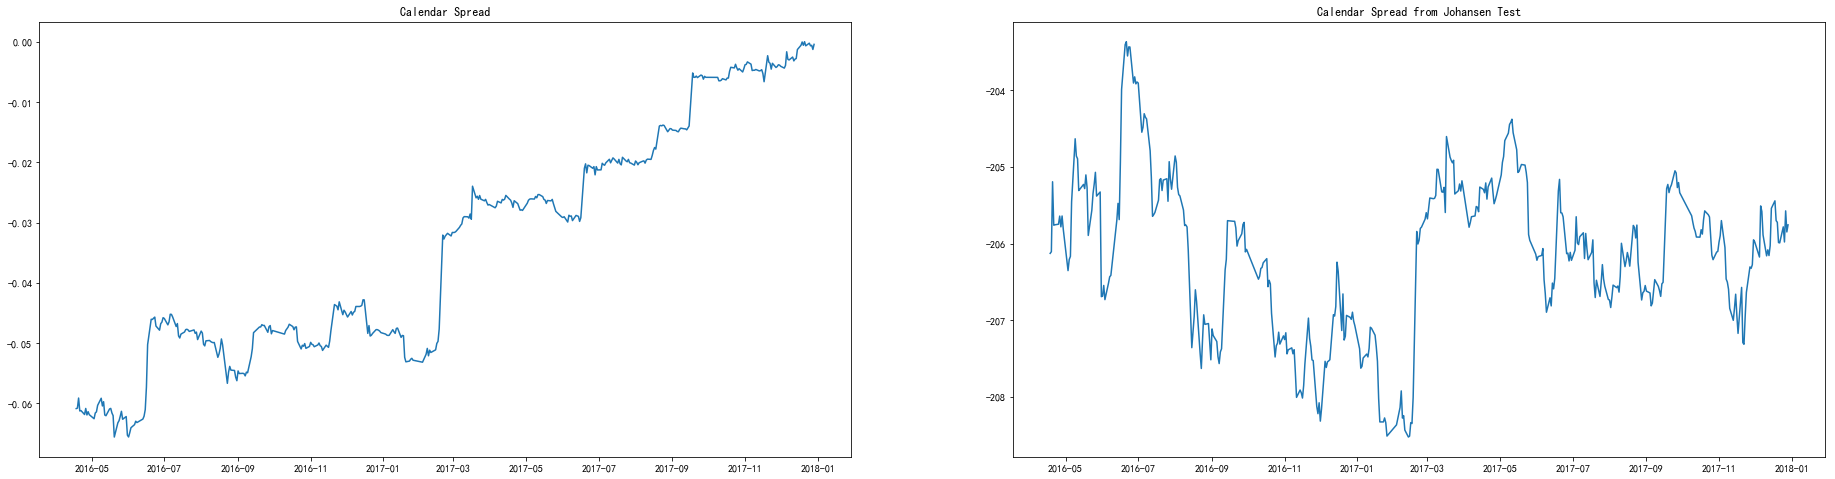

In [40]:
# 计算两个合约的期限价差
# 对连续合约的价格进行前复权调整
AdjCCPrice = pd.DataFrame({iID:QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", 
                                                                            adj_type="收益率不变", rollover_ahead=True) for iID in CCIDs}).loc[:, CCIDs]
# AdjCCPrice = CCPrice
CalendarSpread = np.log(AdjCCPrice.iloc[:, 0]) - np.log(AdjCCPrice.iloc[:, 1])# 当月合约 - 下月合约

# 协整检验
X = np.log(AdjCCPrice.iloc[:, 0:2])
CalendarJohansenTest = sm.tsa.var.vecm.coint_johansen(X, det_order=0, k_ar_diff=1)
for i in range(CalendarJohansenTest.lr1.shape[0]):
    print(("---------- Calendar Cointegration Johansen Test: r<=%d ----------" % (i, )),
          ("Trace Statistic : %f" % (CalendarJohansenTest.lr1[i], )), 
          ("Critical Values (90%%, 95%%, 99%%) : %s" % (str(CalendarJohansenTest.cvt[i]), )), 
          ("Maximum Eigenvalue Statistic Statistic : %f" % (CalendarJohansenTest.lr2[i], )), 
          ("Critical Values (90%%, 95%%, 99%%) : %s" % (str(CalendarJohansenTest.cvm[i]), )), sep="\n", end="\n\n")

Fig, Axes = plt.subplots(1, 2, figsize=(32, 8))
Axes[0].plot(CalendarSpread)
Axes[0].set_title("Calendar Spread")
Axes[1].plot(CalendarSpread.index, np.dot(X, CalendarJohansenTest.evec[:, 0]))
Axes[1].set_title("Calendar Spread from Johansen Test");

3 Contract Calendar Spread ADF Test
Statistic : -1.095016
pvalue : 0.717055
usedlag : 0

---------- 3 Contract Calendar Cointegration Johansen Test: r<=0 ----------
Trace Statistic : 22.866529
Critical Values (90%, 95%, 99%) : [27.0669 29.7961 35.4628]
Maximum Eigenvalue Statistic Statistic : 15.704307
Critical Values (90%, 95%, 99%) : [18.8928 21.1314 25.865 ]

---------- 3 Contract Calendar Cointegration Johansen Test: r<=1 ----------
Trace Statistic : 7.162222
Critical Values (90%, 95%, 99%) : [13.4294 15.4943 19.9349]
Maximum Eigenvalue Statistic Statistic : 7.161762
Critical Values (90%, 95%, 99%) : [12.2971 14.2639 18.52  ]

---------- 3 Contract Calendar Cointegration Johansen Test: r<=2 ----------
Trace Statistic : 0.000460
Critical Values (90%, 95%, 99%) : [2.7055 3.8415 6.6349]
Maximum Eigenvalue Statistic Statistic : 0.000460
Critical Values (90%, 95%, 99%) : [2.7055 3.8415 6.6349]

对冲比例：[ 198.2244661   -46.37126694 -165.91000225]


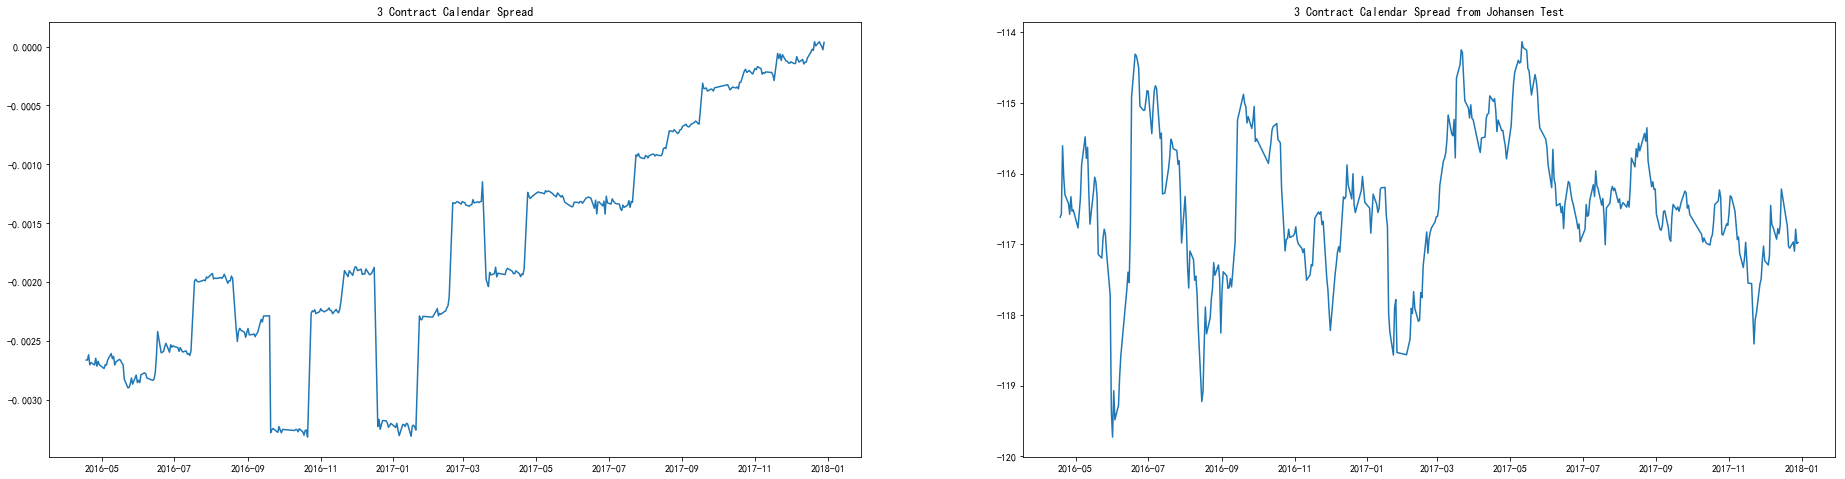

In [41]:
# 计算三个合约的期限价差
# (当月合约 - 下月合约) - (下月合约 - 下下月合约)
Calendar3Spread = (np.log(AdjCCPrice.iloc[:, 0]) - np.log(AdjCCPrice.iloc[:, 1])) / (ExpirationDays.iloc[:, 3] - ExpirationDays.iloc[:, 2])
Calendar3Spread -= (np.log(AdjCCPrice.iloc[:, 1]) - np.log(AdjCCPrice.iloc[:, 2])) / (ExpirationDays.iloc[:, 4] - ExpirationDays.iloc[:, 3])

# 平稳性检验
# ADF 检验
ADFTest = sm.tsa.stattools.adfuller(Calendar3Spread[pd.notnull(Calendar3Spread)].values, regression='c', autolag="BIC")
print("3 Contract Calendar Spread ADF Test",
      ("Statistic : %f" % ADFTest[0]), 
      ("pvalue : %f" % ADFTest[1]), 
      ("usedlag : %d" % ADFTest[2]), sep="\n", end="\n\n")

# 协整检验
X = np.log(AdjCCPrice.iloc[:, 0:3]).values
# X /= ExpirationDays.iloc[:, 2:5].values * 365
Calendar3JohansenTest = sm.tsa.var.vecm.coint_johansen(X, det_order=0, k_ar_diff=1)
for i in range(Calendar3JohansenTest.lr1.shape[0]):
    print(("---------- 3 Contract Calendar Cointegration Johansen Test: r<=%d ----------" % (i, )),
          ("Trace Statistic : %f" % (Calendar3JohansenTest.lr1[i], )), 
          ("Critical Values (90%%, 95%%, 99%%) : %s" % (str(Calendar3JohansenTest.cvt[i]), )), 
          ("Maximum Eigenvalue Statistic Statistic : %f" % (Calendar3JohansenTest.lr2[i], )), 
          ("Critical Values (90%%, 95%%, 99%%) : %s" % (str(Calendar3JohansenTest.cvm[i]), )), sep="\n", end="\n\n")
print("对冲比例："+str(Calendar3JohansenTest.evec[:, 0]))

Fig, Axes = plt.subplots(1, 2, figsize=(32, 8))
Axes[0].plot(Calendar3Spread)
Axes[0].set_title("3 Contract Calendar Spread");
Axes[1].plot(Calendar3Spread.index, np.dot(X, Calendar3JohansenTest.evec[:, 0]))
Axes[1].set_title("3 Contract Calendar Spread from Johansen Test");

# References

[<a id="cit-Chan:2013" href="#call-Chan:2013">Chan:2013</a>] Ernest Chan, ``_Algorithmic trading: winning strategies and their rationale_'',  2013.



1. 知乎，金融投资圈：套利那些事儿系列，https://zhuanlan.zhihu.com/investmentclub.